## Dataset Notes

common_player_info

draft_combine_stats

draft_history

game

game_info

game_summary

inactive_players

line_score

officials

other_stats

play_by_play

player

team

team_details

team_history

team_info_common

Join the greatest 75 players from the *common_player_info* table with the *draft_combine_stats* table using the __player-id__ attribute, in order to compare various statistics like height, weight and speed with the average values of the players not among the greatest 75. - NOT GOING TO WORK

In *play_by_play* table, change values of "TIE" in __scoremargin__ attribute to 0 or zero. - DONE

team_info_common useless table - DONE

team_history until 2019

team_details table can be compared with team_history table and team table

player table has 4815 rows

play_by_play table, keep period, scoremargin and video_available_flag - DONE

other_stats table can be analyzed on its own

officials table useless table - DONE

line_score table can be analyzed on its own, maybe with other_stats table

inactive_players can be joined with common_player_info and analyzed

game_summary useless table on its own, can be combined with game_info table to analyze attendance of games and by team name

game table can be analyzed for various stats

draft_history table is from 1959-1989, can compare various player stats with their overall_pick in the draft

maybe compare player_profile_flag with overall_pick

draft_combine_stats is only for the 2022 season, maybe can compare height and weight of players, as well as position

common_player_info, can compare countries and schools, with height and weight, and position

can compare years active as well

## Imports

In [1]:
import pandas as pd

## NBA GAME ANALYSIS AND VISUALIZATIONS

CSV file created using the results of the following SQL statement:

**select game_id, period, scoremargin, video_available_flag, wl_home FROM play_by_play join game using(game_id);**

In [ ]:
NBA_GAME_STATS_FILE = 'nba_game_stats.csv'

In [ ]:
play_by_play = pd.read_csv(NBA_GAME_STATS_FILE, index_col="game_id", dtype={'game_id': 'string'})
play_by_play

In [ ]:
play_by_play = play_by_play.dropna(subset='scoremargin')

In [ ]:
play_by_play

In [ ]:
play_by_play.columns

In [ ]:
nba_df_copy = play_by_play.copy()

In [ ]:
nba_df_copy

In [ ]:
score_margin = nba_df_copy['scoremargin'].copy()

In [ ]:
score_margin = score_margin.replace({'TIE': 0})
score_margin

In [ ]:
nba_df_copy['scoremargin'] = score_margin

In [ ]:
nba_df_copy

In [ ]:
nba_df_copy = nba_df_copy.astype({'scoremargin': 'int64'})

In [ ]:
nba_df_copy = nba_df_copy.convert_dtypes()

In [ ]:
nba_df_copy.dtypes

In [ ]:
(nba_df_copy
    .groupby('video_available_flag')
    .mean(numeric_only=True)
    .rename(index={0: 'No', 1: 'Yes'})
    .plot
    .bar(title="Average Period and Score Margin Vs Video Available", rot=1)
);

From this histogram, a prediction can be made that home teams (positive values) win NBA games more often than visitor teams (negative values)

In [ ]:
nba_df_copy[['scoremargin']].plot.hist()

Now only using the 8th period (the maximum, or last, period), a prediction can be made that visitor teams (negative values) win NBA games more often than home teams (positive values)

In [ ]:
(nba_df_copy
.loc[
    nba_df_copy['period'] == nba_df_copy['period'].max()
    ]
[['scoremargin']]
.plot.hist())

In conclusion, it appears that home teams often have a higher score margin throughout the duration of the game. However, visitor teams often have a larger score margin during the last period (8) of games. Therefore, it can be predicted that visitor teams win games more often than home teams because their score margin is oftentimes higher during the last period of the game.

A caveat of this prediction, though, is that the number of score margin values during the 8th period is only 83, much less than during other periods of the game, so it is more likely that home teams win games more often than visitor teams.

In [ ]:
nba_df_copy['period'].value_counts()

Examining the 4th period, which has a lot more data points than the 8th period, we can see that indeed the score margin for the home teams is greater than that of the visitor teams.

In [ ]:
nba_df_copy.loc[nba_df_copy['period'] == 4][['scoremargin']].plot.hist()

The assumption has been that the more often that a team has a higher score margin, then the more likely it is that they are winning more often.

However, this is simply an assumption and is not based on evidence. Therefore, we will compare scoremargin with win/loss records to see if there is validity to the above claim.

In [ ]:
nba_df_wl = nba_df_copy.copy()
nba_df_wl = (
    nba_df_wl[['wl_home']]
    .reset_index()
    .drop_duplicates(subset=['game_id'])
    .sort_values('game_id')
    .set_index('game_id')
    )
nba_df_wl

In [ ]:
nba_scoremargin_wl = (
    nba_df_wl
    .join(nba_df_copy
          .reset_index()
          [['game_id', 'scoremargin', 'wl_home']]
          .groupby('game_id')
          .mean(numeric_only=True)
          )
    )

In [ ]:
nba_scoremargin_wl

In [ ]:
nba_scoremargin_wl = nba_scoremargin_wl.astype({'scoremargin': 'string'})
nba_scoremargin_wl.dtypes

In [ ]:
nba_scoremargin_wl['scoremargin'] = (
    nba_scoremargin_wl['scoremargin']
    .mask(nba_scoremargin_wl['scoremargin']
          .astype(float) < 0, 'L')
    .mask(nba_scoremargin_wl['scoremargin']
          .astype(float) > 0, 'W')
    )
nba_scoremargin_wl

In [ ]:
nba_scoremargin_wl['scoremargin'].unique()

In [ ]:
nba_scoremargin_wl.loc[nba_scoremargin_wl['scoremargin'] == '0.0']

In [ ]:
nba_scoremargin_wl['wl_home'].unique()

In [ ]:
nba_scoremargin_wl = nba_scoremargin_wl.dropna(subset='wl_home')

In [ ]:
nba_scoremargin_wl.loc[nba_scoremargin_wl['wl_home'].isna()]

In [ ]:
print(f"{round((
    len(nba_scoremargin_wl.loc[nba_scoremargin_wl['scoremargin'] != nba_scoremargin_wl['wl_home']])
    / len(nba_scoremargin_wl)) * 100)}%\
 of the time, the result of a game is not equal to the average recorded score margin for the respective side.")

In [ ]:
print(f"Home teams have won \
      {round((
          len(nba_scoremargin_wl.loc[nba_scoremargin_wl['wl_home'] == 'W'])
          / len(nba_scoremargin_wl)) * 100)}% of the time.")

print(f"Home teams have had an average score margin advantage \
      {round((len(nba_scoremargin_wl.loc[nba_scoremargin_wl['scoremargin'] == 'W'])
      / len(nba_scoremargin_wl)) * 100)}% of the time.")

## NBA PLAYER ANALYSIS AND VISUALIZATIONS

CSV file created using the results of the following SQL statement:

**select height, weight, from_year, to_year, display_first_last, game_id**

**from common_player_info cpi join inactive_players ip on cpi.person_id = ip.player_id;**

In [2]:
NBA_PLAYER_STATS_FILE = 'nba_player_stats.csv'

In [6]:
player_stats = pd.read_csv(
    NBA_PLAYER_STATS_FILE,
    index_col="player_id",
    dtype={'game_id': 'string', 'player_id': 'string'}
    )
player_stats

,height,weight,from_year,to_year,display_first_last,game_id
player_id,,,,,,
203518,6-6,200.0,2016.0,2018.0,Alex Abrines,0021600740
203518,6-6,200.0,2016.0,2018.0,Alex Abrines,0021600750
203518,6-6,200.0,2016.0,2018.0,Alex Abrines,0021601167
203518,6-6,200.0,2016.0,2018.0,Alex Abrines,0021601186
203518,6-6,200.0,2016.0,2018.0,Alex Abrines,0021601198
...,...,...,...,...,...,...
1627826,7-0,240.0,2016.0,2022.0,Ivica Zubac,0022200427
1627826,7-0,240.0,2016.0,2022.0,Ivica Zubac,0022200438
1627826,7-0,240.0,2016.0,2022.0,Ivica Zubac,0022200902


In [14]:
player_name_separate = player_stats.copy()
player_name_separate = (
    player_name_separate[['display_first_last']]
                        .reset_index()
                        .drop_duplicates(subset=['player_id'])
                        .set_index('player_id')
                        )
player_name_separate

,display_first_last
player_id,
203518,Alex Abrines
1630173,Precious Achiuwa
203112,Quincy Acy
1629121,Jaylen Adams
203500,Steven Adams
...,...
203469,Cody Zeller
678,George Zidek
1627757,Stephen Zimmerman


In [21]:
(player_name_separate
 .join(player_stats[['game_id', 'display_first_last']]
       .reset_index()
       .groupby('player_id')
       .size()
       .to_frame('Number of games played'))
 .sort_values('Number of games played', ascending=False)
)

,display_first_last,Number of games played
player_id,,
202322,John Wall,279
2760,Anderson Varejao,260
202347,Quincy Pondexter,239
2397,Yao Ming,239
689,Theo Ratliff,223
...,...,...
42,Monty Williams,1
1629341,Tarik Phillip,1
281,Scott Williams,1


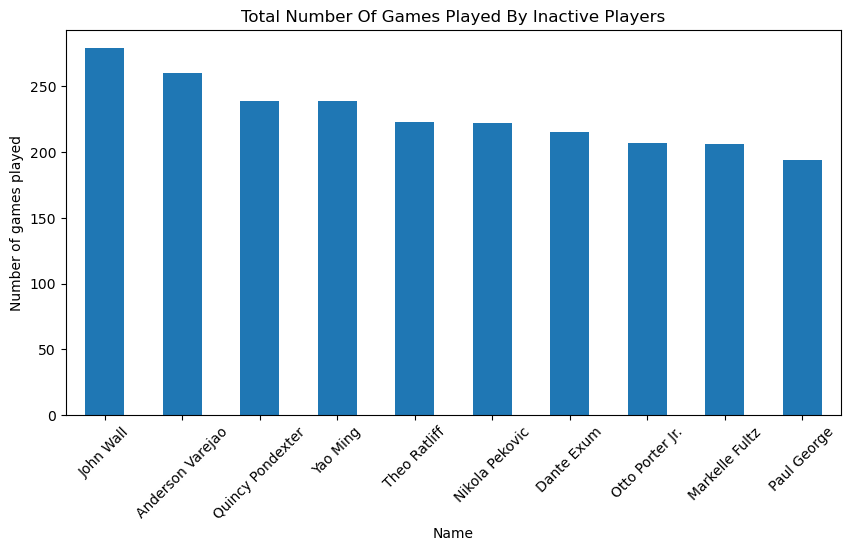

In [37]:
(player_name_separate
 .join(player_stats[['game_id', 'display_first_last']]
       .reset_index()
       .groupby('player_id')
       .size()
       .to_frame('Number of games played'))
 .nlargest(10, 'Number of games played')
).plot.bar(x='display_first_last', rot=45, figsize=(10,5), xlabel="Name", ylabel="Number of games played",
           title="Total number of games played by inactive players".title(), legend=False);

## NBA TEAM ANALYSIS AND VISUALIZATIONS

CSV file created using the results of the following SQL statement:

**select th.city, th.nickname, (th.city || ' ' || th.nickname) as "full_name", th.year_founded, year_active_till, arena, arenacapacity**

**from team t join team_history th on t.id = th.team_id left join team_details td**

**on (th.city || ' ' || th.nickname) = (td.city || ' ' || td.nickname);**

In [38]:
NBA_TEAM_STATS_FILE = 'nba_team_stats.csv'

In [42]:
team_stats = pd.read_csv(NBA_TEAM_STATS_FILE)
team_stats.sort_values('year_founded')

,city,nickname,full_name,year_founded,year_active_till,arena,arenacapacity
13,Philadelphia,Warriors,Philadelphia Warriors,1946,1961,NaN,NaN
4,Boston,Celtics,Boston Celtics,1946,2019,TD Garden,18624.0
27,Ft. Wayne Zollner,Pistons,Ft. Wayne Zollner Pistons,1948,1956,NaN,NaN
3,Tri-Cities,Blackhawks,Tri-Cities Blackhawks,1949,1950,NaN,NaN
1,Milwaukee,Hawks,Milwaukee Hawks,1951,1954,NaN,NaN
2,St. Louis,Hawks,St. Louis Hawks,1955,1967,NaN,NaN
26,Detroit,Pistons,Detroit Pistons,1957,2019,Little Caesars Arena,NaN
14,San Francisco,Warriors,San Francisco Warriors,1962,1970,NaN,NaN
9,Chicago,Bulls,Chicago Bulls,1966,2019,United Center,21711.0
0,Atlanta,Hawks,Atlanta Hawks,1968,2019,State Farm Arena,18729.0
